# Hindmarsh-Rose model bursting analysis

In [1]:
import brainpy as bp
import brainpy.math as bm

The Hindmarsh-Rose model describes bursting dynamics in neurons.

"x" models the membrane potential of a bursting cell,
"y" models the main currents into and out of the cell, and
"z" models an adaptive (calcium-like) current.

In [2]:
class HR(bp.NeuGroup):
    @staticmethod
    def derivative(V, y, z, t, a, b, c, d, r, s, x_r, Isyn):
        dV = y - a * V ** 3 + b * V * V - z + Isyn
        dy = c - d * V * V - y
        dz = r * (s * (V - x_r) - z)
        return dV, dy, dz

    def __init__(self, size, a=1., b=3., c=1., d=5., s=4., x_r=-1.6,
                 r=0.001, Vth=1.9, **kwargs):
        super(HR, self).__init__(size=size, **kwargs)
        
        # parameters
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.s = s
        self.x_r = x_r
        self.r = r
        self.Vth = Vth

        # variables
        self.V = bm.Variable(-1.6 * bm.ones(self.num))
        self.y = bm.Variable(-10 * bm.ones(self.num))
        self.z = bm.Variable(bm.zeros(self.num))
        self.spike = bm.Variable(bm.zeros(self.num, dtype=bool))
        self.input = bm.Variable(bm.zeros(self.num))

        self.integral = bp.odeint(f=self.derivative)

    def update(self, _t, _dt):
        V, y, z = self.integral(self.V, self.y, self.z, _t,
                                self.a, self.b, self.c, self.d,
                                self.r, self.s, self.x_r, self.input)
        self.spike[:] = (V >= self.Vth) * (self.V < self.Vth)
        self.V[:] = V
        self.y[:] = y
        self.z[:] = z
        self.input[:] = 0.

### Simulation

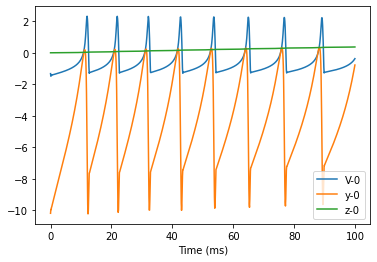

In [3]:
group = HR(1, monitors=['V', 'y', 'z'])

group.run(100., inputs=('input', 1.))
bp.visualize.line_plot(group.mon.ts, group.mon.V, legend='V', )
bp.visualize.line_plot(group.mon.ts, group.mon.y, legend='y', )
bp.visualize.line_plot(group.mon.ts, group.mon.z, legend='z', show=True)

### Phase plane analysis

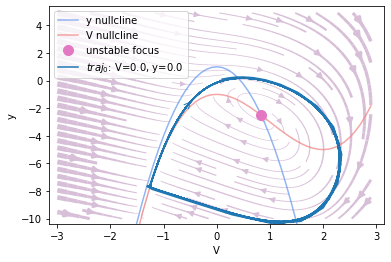

In [4]:
analyzer = bp.symbolic.PhasePlane(
    group.integral,
    target_vars={'V': [-3, 3], 'y': [-10., 5.]},
    fixed_vars={'z': 0.},
    pars_update=dict(a=1., b=3., c=1., d=5., s=4., x_r=-1.6, r=0.001, Isyn=1.)
)
analyzer.plot_nullcline()
analyzer.plot_vector_field()
analyzer.plot_fixed_point()
analyzer.plot_trajectory([{'V': 0., 'y': 0.}],
                         duration=100.,
                         show=True)

## Bifurcation Diagram

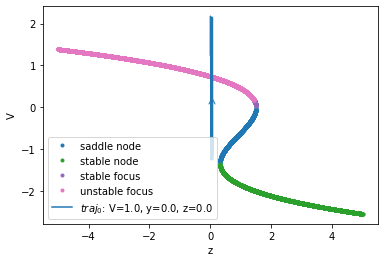

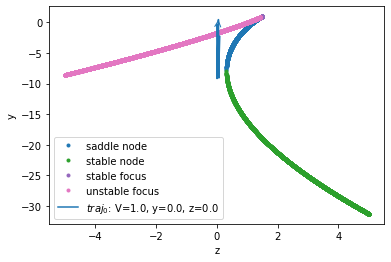

In [5]:
analyzer = bp.symbolic.FastSlowBifurcation(
    group.integral,
    fast_vars={'V': [-3, 3], 'y': [-10., 5.]},
    slow_vars={'z': [-5., 5.]},
    pars_update=dict(a=1., b=3., c=1., d=5., s=4., x_r=-1.6, r=0.001, Isyn=.5),
    numerical_resolution=0.001
)
analyzer.plot_bifurcation()
analyzer.plot_trajectory([{'V': 1., 'y': 0., 'z': 0.0}],
                         duration=30.,
                         show=True)

**References**:

- James L Hindmarsh and RM Rose. A model of neuronal bursting using
  three coupled first order differential equations. Proceedings
  of the Royal society of London. Series B. Biological sciences,
  221(1222):87–102, 1984.